# ENVIRONMENT

In [ ]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

# ACQUIRE

In [ ]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [ ]:
df.head()

In [ ]:
df.info()

## Parse timestamp

In [ ]:
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')

## Cleanup text

In [ ]:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

In [ ]:
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [ ]:
df.describe()

In [ ]:
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_count'})
ip_df2 = pd.DataFrame(df.ip.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})
ip_df = ip_df.merge(ip_df2)


# see those where rate < 1% 
ip_df[ip_df.ip_proba < .01]

In [ ]:
print(len(ip_df))

print(ip_df.tail(10))

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=ip_df, x = 'ip', y = 'ip_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

In [ ]:
df.head(10)

In [ ]:
train = df['2019-04-16 19:34:42':'2019-04-17 12:55:14'][['ip','request_method','status','size','destination','request_agent','size_mb']]

In [ ]:
train.head(10)

In [ ]:
request_df = pd.DataFrame(train.request_agent.value_counts(dropna=False)/train.request_agent.count()).reset_index().\
                rename(index=str, columns={'index': 'request_agent', 'request_agent': 'request_agent_proba'})

In [ ]:
request_df

In [ ]:
df = df.reset_index().merge(request_df, on=['request_agent'], how='left').fillna(value=0).set_index('timestamp')
df.request_agent.value_counts()

In [ ]:
request_probs = train.groupby('request_agent').size().div(len(df))

status_given_request = pd.DataFrame(train.groupby(['request_agent', 'status']).\
                               size().div(len(train)).\
                               div(request_probs, 
                                   axis=0, 
                                   level='request_agent').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_status_given_request'})
                              )

In [ ]:
request_status_count = pd.DataFrame(train.groupby(['request_agent', 'status'])['request_method'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'request_method': 'request_status_count'}))


request_status = status_given_request.merge(request_status_count)

In [ ]:
df = df.reset_index().merge(request_status, on=['request_agent', 'status'], how='left').fillna(value=0).set_index('timestamp')

In [ ]:
df.head(10)

In [ ]:
plt.scatter(df.proba_status_given_request, df.request_agent_proba)

# Stats & Time-Series

In [ ]:
df_ts_size = df['size_mb'].resample('30T').max()

idx = pd.date_range(
    df_ts_size.sort_index().index.min(), 
    df_ts_size.sort_index().index.max(),
    freq='30min'
)

df_ts_size = df_ts_size.reindex(idx, fill_value=0).fillna(value=0)

In [ ]:
df.info()

## Train/Test Split

In [ ]:
start_date_train = df_ts_size.head(1).index[0]
end_date_train = '2019-04-18 23:30:00'
start_date_test = '2019-04-19 00:00:00'

train_ts_size = df_ts_size[:end_date_train]
test_ts_size = df_ts_size[start_date_test:]

plt.figure(figsize=(12, 8))
plt.plot(train_ts_size)
plt.plot(test_ts_size)
plt.show()

## SMA - Simple Moving Average

In [ ]:
# Calculating the short-window simple moving average
short_rolling = train_ts_size.rolling(window=12).mean()

# Calculating the long-window simple moving average
long_rolling = train_ts_size.rolling(window=24).mean()

In [ ]:
# fig, ax = plt.subplots(figsize=(12,4))

# ax.plot(train_ts_size.index, 
#         train,
#         label='Size (MB)')

# ax.plot(short_rolling.index, 
#         short_rolling, 
#         label = '6-Hour SMA')
# ax.plot(long_rolling.index, 
#         long_rolling, 
#         label = '12-Hour SMA')

# ax.legend(loc='best')
# ax.set_ylabel('Size (MB)')

## Compute the EMA

In [ ]:
# Using Pandas to calculate a 2 hour span EMA. 
# adjust=False specifies that we are interested in the 
# recursive calculation mode.
ema_short = train_ts_size.ewm(span=12, adjust=False).mean()
ema_short[0:3]

ema_long = train_ts_size.ewm(span=24, adjust=False).mean()
ema_long[0:3]

## Compare SMA with EMA

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train_ts_size.index, 
        train_ts_size,
        label='Size (MB)')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '6-Hour SMA')
ax.plot(long_rolling.index, 
        ema_short, 
        label = 'Span 6-Hour EMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '12-Hour SMA')
ax.plot(long_rolling.index, 
        ema_long, 
        label = 'Span 12-Hour EMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

yhat = pd.DataFrame(dict(actual=test_ts_size))

# Forecast using the EMA

In [ ]:
ema_long = train_ts_size.ewm(span=24, adjust=False).mean()
midband = ema_long[-1]
ub = midband + ema_long[-24:-1].std()*3
lb = midband - ema_long[-24:-1].std()*3

yhat['moving_avg_forecast'] = midband

## Compute the `%b` for each record

In [ ]:
# compute the absolute error:
yhat['error'] = abs(yhat.actual - yhat.moving_avg_forecast)

# compute the mean of the absolute error:
# yhat.error.median()

# compute upper band and lower band using IQR with weight of 3

yhat['pct_b'] = (yhat.actual-lb)/(ub-lb)

## Extract the anomalies

In [ ]:
yhat[yhat.pct_b > 1]

# RIGHTIE - OH

In [ ]:
df.info()

In [ ]:
df.head()

# DBSCAN

In [ ]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [ ]:
# Import .csv file and convert it to a DataFrame object
df = pd.read_csv("customers.csv")

df.head()

In [ ]:
# df.drop(["Channel", "Region"], axis = 1, inplace = True)
df = df[["Grocery", "Milk","Fresh"]]

In [ ]:
np_array = df.values.astype("float32", copy = False)
np_array[0:10]

In [ ]:
stscaler = StandardScaler().fit(np_array)
np_array = stscaler.transform(np_array)
np_array[0:10]

In [ ]:
dbsc = DBSCAN(eps = .75, min_samples = 15).fit(np_array)

In [ ]:
labels = dbsc.labels_
labels[0:10]

In [ ]:
df['labels'] = labels
df.labels.value_counts()

In [ ]:
df[df.labels==-1].head()

In [ ]:
sns.scatterplot(df.Grocery, df.Fresh, hue=df.labels)
plt.show()

sns.scatterplot(df.Milk, df.Fresh, hue=df.labels)
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.Fresh, df.Milk, df.Grocery,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Fresh')
ax.set_ylabel('Milk')
ax.set_zlabel('Grocery')

# DBSCAN Exercise

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

In [ ]:
X, y = make_moons(n_samples=1000, noise=0.1)
dbscan = DBSCAN(eps=0.09, min_samples=5)
dbscan.fit(X)

In [ ]:
labels = dbscan.labels_
labels[0:10]

In [ ]:
df = pd.DataFrame(X,y, columns=['X','y'])

In [ ]:
df['labels'] = labels
df.labels.value_counts()

In [ ]:
df[df.labels==-1].head(30)

In [ ]:
sns.scatterplot(df.X, df.y, hue=df.labels)
plt.show()

# DBSCAN - ZILLOW

In [50]:
import pandas as pd
import ddflowwzillow as dd


%matplotlib inline
import numpy as np
import scipy.stats as st
from sci_analysis import analyze

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D



In [23]:
df_orig = pd.read_csv('zillow.csv',          
                 engine='python')

In [24]:
df_orig.columns

Index(['parcelid', 'logerror', 'transactiondate', 'id',
       'airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft',
       'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       '

In [25]:
# df = df_orig.sample(50000)
df = df_orig

In [26]:
df.shape

(167888, 68)

In [27]:
df = dd.prep_zillow(df)

In [28]:
df.head(10)

,parcelid,logerror,transactiondate,id,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,...,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,propertylandusedesc,heatingorsystemdesc
0,11016594,0.0276,2016-01-01,2931667,2.0,3.0,4.0,2.0,1684.0,1684.0,...,1.0,1959.0,122754.0,360170.0,2015.0,237416.0,6735.88,6.037107e+13,Single Family Residential,Central
1,14366692,-0.1684,2016-01-01,475764,3.5,4.0,NaN,3.5,2263.0,2263.0,...,NaN,2014.0,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,Single Family Residential,NaN
2,12098116,-0.0040,2016-01-01,2444575,3.0,2.0,4.0,3.0,2217.0,2217.0,...,1.0,1940.0,61994.0,119906.0,2015.0,57912.0,11484.48,6.037464e+13,Single Family Residential,Central
3,12643413,0.0218,2016-01-02,1584730,2.0,2.0,4.0,2.0,839.0,839.0,...,1.0,1987.0,171518.0,244880.0,2015.0,73362.0,3048.74,6.037296e+13,Condominium,Central
4,14432541,-0.0050,2016-01-02,2926916,2.5,4.0,NaN,2.5,2283.0,2283.0,...,NaN,1981.0,169574.0,434551.0,2015.0,264977.0,5488.96,6.059042e+13,Single Family Residential,NaN
5,11509835,-0.2705,2016-01-02,2843942,4.0,4.0,1.0,4.0,3067.0,3067.0,...,1.0,1982.0,880650.0,2447951.0,2015.0,1567301.0,27126.57,6.037621e+13,Single Family Residential,Central
6,12286022,0.0440,2016-01-02,1628001,1.0,2.0,7.0,1.0,1297.0,1297.0,...,1.0,1939.0,64549.0,111521.0,2015.0,46972.0,2304.97,6.037542e+13,Single Family Residential,Floor/Wall
7,17177301,0.1638,2016-01-02,2543293,2.5,3.0,NaN,2.5,1763.0,1763.0,...,NaN,1994.0,107000.0,306000.0,2015.0,199000.0,3745.50,6.111003e+13,Condominium,NaN
8,14739064,-0.0030,2016-01-02,519006,1.0,2.0,NaN,1.0,796.0,796.0,...,NaN,1984.0,66834.0,210064.0,2015.0,143230.0,2172.88,6.059042e+13,Condominium,NaN
9,14677559,0.0843,2016-01-03,1604540,2.0,2.0,NaN,2.0,1260.0,1260.0,...,NaN,1977.0,109977.0,190960.0,2015.0,80983.0,1940.26,6.059063e+13,Condominium,NaN


In [29]:
dd.missing_values_col(df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
parcelid,0,0.000000,0,0.0,0,0.0
logerror,0,0.000000,0,0.0,0,0.0
transactiondate,0,0.000000,0,0.0,0,0.0
id,0,0.000000,0,0.0,0,0.0
bathroomcnt,0,0.000000,0,0.0,0,0.0
bedroomcnt,0,0.000000,0,0.0,0,0.0
buildingqualitytypeid,56577,34.804407,0,0.0,0,0.0
calculatedbathnbr,106,0.065208,0,0.0,0,0.0
calculatedfinishedsquarefeet,22,0.013534,0,0.0,0,0.0
finishedsquarefeet12,5690,3.500311,0,0.0,0,0.0


In [30]:
df = dd.remove_columns(df, cols_to_remove=['buildingqualitytypeid', 'heatingorsystemtypeid', 'propertyzoningdesc',
              'unitcnt', 'heatingorsystemdesc'])

In [31]:
df.shape

(162557, 29)

In [38]:
df = df[["logerror", "bathroomcnt","bedroomcnt"]]

In [40]:
np_array = df.values.astype("float32", copy = False)
np_array[0:10]

array([[ 2.760e-02,  2.000e+00,  3.000e+00],
       [-1.684e-01,  3.500e+00,  4.000e+00],
       [-4.000e-03,  3.000e+00,  2.000e+00],
       [ 2.180e-02,  2.000e+00,  2.000e+00],
       [-5.000e-03,  2.500e+00,  4.000e+00],
       [-2.705e-01,  4.000e+00,  4.000e+00],
       [ 4.400e-02,  1.000e+00,  2.000e+00],
       [ 1.638e-01,  2.500e+00,  3.000e+00],
       [-3.000e-03,  1.000e+00,  2.000e+00],
       [ 8.430e-02,  2.000e+00,  2.000e+00]], dtype=float32)

In [43]:
stscaler = StandardScaler().fit(np_array)
np_array = stscaler.transform(np_array)
np_array[0:10]

array([[ 0.08716773, -0.2836683 , -0.01337104],
       [-1.1261045 ,  1.4051989 ,  0.97192186],
       [-0.10844145,  0.8422432 , -0.99866396],
       [ 0.05126478, -0.2836683 , -0.99866396],
       [-0.11463162,  0.27928746,  0.97192186],
       [-1.7581203 ,  1.9681548 ,  0.97192186],
       [ 0.18868642, -1.4095799 , -0.99866396],
       [ 0.93026805,  0.27928746, -0.01337104],
       [-0.10225129, -1.4095799 , -0.99866396],
       [ 0.43815002, -0.2836683 , -0.99866396]], dtype=float32)

In [44]:
dbsc = DBSCAN(eps = .75, min_samples = 15).fit(np_array)

In [45]:
labels = dbsc.labels_
labels[0:10]

array([0, 1, 2, 2, 1, 1, 2, 0, 2, 2])

In [46]:
df['labels'] = labels
df.labels.value_counts()

 0     65466
 2     41464
 1     36003
 4      7226
 3      7129
 5      1337
 10      787
-1       756
 8       608
 12      418
 7       339
 13      162
 11      107
 14      101
 17       86
 9        84
 6        69
 19       59
 23       52
 24       37
 20       31
 29       28
 25       27
 16       25
 28       24
 22       22
 27       22
 21       21
 18       19
 15       18
 30       15
 26       15
Name: labels, dtype: int64

In [47]:
df[df.labels==-1].head()

,logerror,bathroomcnt,bedroomcnt,labels
106,-0.1473,8.0,7.0,-1
163,0.1089,9.0,7.0,-1
799,-0.2421,7.0,7.0,-1
1012,-0.8557,1.0,1.0,-1
1052,-0.6616,6.0,6.0,-1


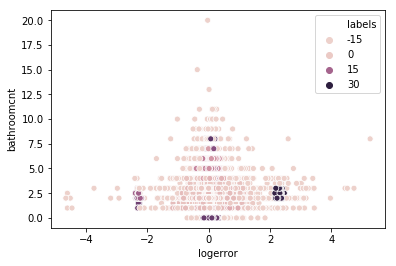

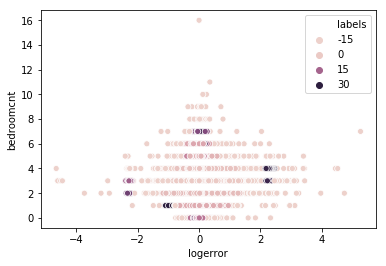

In [49]:
sns.scatterplot(df.logerror, df.bathroomcnt, hue=df.labels)
plt.show()

sns.scatterplot(df.logerror, df.bedroomcnt, hue=df.labels)
plt.show()

Text(0.5, 0, 'Bedroom Count')

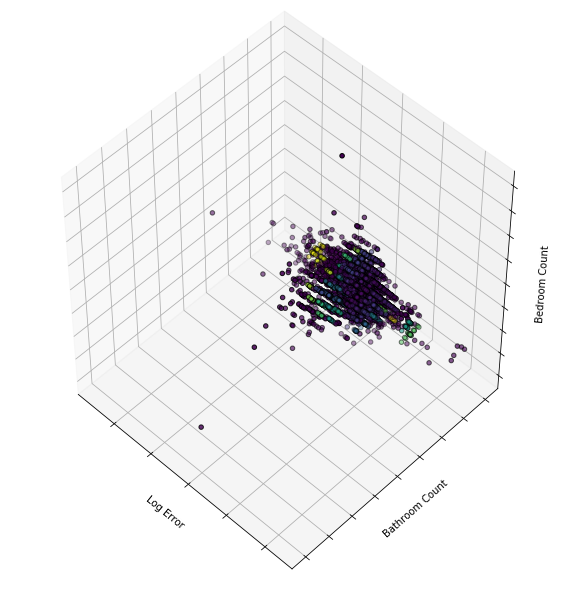

In [51]:
fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.logerror, df.bathroomcnt, df.bedroomcnt,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Log Error')
ax.set_ylabel('Bathroom Count')
ax.set_zlabel('Bedroom Count')